## Import the libraries

In [1]:
import os
import pandas as pd
import yfinance as yf
from newsapi import NewsApiClient
from datetime import datetime, timedelta
from dotenv import load_dotenv
load_dotenv()

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

## Fetch the stock OHLC

In [2]:
stock_data= yf.download(tickers= 'MSFT', period= '5y')
stock_data.tail()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-01-04,222.529999,223.000000,214.809998,217.690002,217.690002,37130100
2021-01-05,217.259995,218.520004,215.699997,217.899994,217.899994,23823000
2021-01-06,212.169998,216.490005,211.940002,212.250000,212.250000,35930700
2021-01-07,214.039993,219.339996,213.710007,218.289993,218.289993,27694500
2021-01-08,218.679993,220.580002,217.029999,219.619995,219.619995,22949400


In [3]:
# Get only the closing price and round to 1 decimal
stock_close= round (stock_data['Close'], 1)
stock_close.tail()

Date
2021-01-04    217.7
2021-01-05    217.9
2021-01-06    212.2
2021-01-07    218.3
2021-01-08    219.6
Name: Close, dtype: float64

In [4]:
# Calculate the daily returns
returns= stock_close.pct_change().dropna()
returns.tail()

Date
2021-01-04   -0.021133
2021-01-05    0.000919
2021-01-06   -0.026159
2021-01-07    0.028746
2021-01-08    0.005955
Name: Close, dtype: float64

In [69]:
returns_df= pd.DataFrame(returns)
returns_df.sort_index(ascending= False, inplace= True)

returns_df.rename(columns= {'Close':'pct_change'}, inplace= True)
returns_df.head()

,pct_change
Date,
2021-01-08,0.005955
2021-01-07,0.028746
2021-01-06,-0.026159
2021-01-05,0.000919
2021-01-04,-0.021133


### Download the VADER Lexicon

In [6]:
nltk.download('vader_lexicon')

# Initialize the sentiment analyzer
analyzer= SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\sathe\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [7]:
# Reading the News API key enviroment variable
api_key= os.getenv("NEWS_API_KEY2")

# Create a newsapi client
newsapi= NewsApiClient(api_key= api_key)
type (api_key)

str

### Fetch the news

In [8]:
# Fetch the most recent new about ---- stock
stock_news = newsapi.get_everything(q="microsoft AND stock AND price", 
                                    language="en",
                                    sort_by= 'publishedAt'
                                   )

# Print total articles
print(f"Total articles about --- stock: {stock_news['totalResults']}")

# Show sample article
len (stock_news['articles'])

Total articles about --- stock: 893


20

In [31]:
stock_news['articles'][0]

{'source': {'id': None, 'name': 'NDTV News'},
 'author': None,
 'title': "Dr Prannoy Roy, Ruchir Sharma On 2021's Top 10 Trends: Full Transcript",
 'description': "Global investor and author Ruchir Sharma discussed the top ten trends of the year 2021 in a discussion with NDTV's Dr Prannoy Roy. Mr Sharma, in his forecast, said, this year, inflation and interest rates could rise, it might just be the best time to invest i…",
 'url': 'https://www.ndtv.com/india-news/dr-prannoy-roy-investor-ruchir-sharma-on-2021s-top-10-trends-full-transcript-2350350',
 'urlToImage': 'https://c.ndtvimg.com/2021-01/7ors3kr_dr-prannoy-roy-investor-ruchir-sharma-on-2021s-top-10-trends-highlights_625x300_09_January_21.jpg',
 'publishedAt': '2021-01-10T09:22:55Z',
 'content': 'Global investor and author Ruchir Sharma discussed the top ten trends of the year 2021\r\nNew Delhi: Global investor and author Ruchir Sharma discussed the top ten trends of the year 2021 in a discussi… [+45193 chars]'}

### Create the sentiment scores DF

In [71]:
stock_sentiment= []

for article in stock_news['articles']:
    try:
        text= article['content']
        date= article['publishedAt'][:10]
        
        # Calculate the polarity score
        sentiment= analyzer.polarity_scores(text)
        compound= sentiment['compound']
        positive= sentiment['pos']
        negative= sentiment['neg']
        neutral= sentiment['neu']
        
        stock_sentiment.append({
            "text": text,
            "date": date,
            "compound": compound,
            "positive": positive,
            "negative": negative,
            "neutral": neutral
        })
        
    except AttributeError:
        pass
    
# Create dataframe
stock_sentiment_df= pd.DataFrame(stock_sentiment)

In [72]:
# Reorder DataFrame columns
cols = ["date", "text", "compound", "positive", "negative", "neutral"]
stock_sentiment_df= stock_sentiment_df[cols]
stock_sentiment_df.head()

,date,text,compound,positive,negative,neutral
0,2021-01-10,Global investor and author Ruchir Sharma discu...,0.3818,0.096,0.000,0.904
1,2021-01-09,Concerns are rising over the emergence of new-...,0.2732,0.096,0.064,0.841
2,2021-01-09,Investment house Cerno Capital is a small 'bou...,0.1779,0.049,0.000,0.951
3,2021-01-09,"In this article, we presented short selling le...",0.2732,0.097,0.040,0.863
4,2021-01-09,"In this episode of Rule Breaker Investing, Mot...",-0.2732,0.094,0.147,0.759


In [73]:
stock_sentiment_df.set_index('date', inplace= True)
stock_sentiment_df.head()

,text,compound,positive,negative,neutral
date,,,,,
2021-01-10,Global investor and author Ruchir Sharma discu...,0.3818,0.096,0.000,0.904
2021-01-09,Concerns are rising over the emergence of new-...,0.2732,0.096,0.064,0.841
2021-01-09,Investment house Cerno Capital is a small 'bou...,0.1779,0.049,0.000,0.951
2021-01-09,"In this article, we presented short selling le...",0.2732,0.097,0.040,0.863
2021-01-09,"In this episode of Rule Breaker Investing, Mot...",-0.2732,0.094,0.147,0.759


In [74]:
# Descriptive statistics
stock_sentiment_df.describe()

,compound,positive,negative,neutral
count,20.000000,20.000000,20.000000,20.000000
mean,0.115205,0.071250,0.041750,0.887050
std,0.420005,0.061808,0.053922,0.073708
min,-0.670500,0.000000,0.000000,0.743000
25%,-0.062500,0.000000,0.000000,0.850000
50%,0.225550,0.067000,0.000000,0.886500
75%,0.381800,0.097250,0.081000,0.938250
max,0.734300,0.209000,0.147000,1.000000


In [78]:
# Set current date and the date from one month ago using the ISO format
current_date = pd.Timestamp("2021-01-10", tz="America/New_York").isoformat()
past_date = pd.Timestamp("2020-12-10", tz="America/New_York").isoformat()

## Define a function to fetch the news articles in the last 1 month

In [79]:
# Use newsapi client to get most relevant 20 headlines per day in the past month
def get_headlines(keyword):
    all_headlines = []
    all_dates = []    
    
    date = datetime.strptime(current_date[:10], "%Y-%m-%d")
    end_date = datetime.strptime(past_date[:10], "%Y-%m-%d")
    print(f"Fetching news about '{keyword}'")
    print("*" * 30)
    
    while date > end_date:
        print(f"retrieving news from: {date}")
        articles = newsapi.get_everything(
            q=keyword,
            from_param=str(date),
            to=str(date),
            language="en",
            sort_by="relevancy",
            page=1,
        )
        headlines = []
        
        for i in range(0, len(articles["articles"])):
            headlines.append(articles["articles"][i]["title"])
        
        all_headlines.append(headlines)
        all_dates.append(date)
        date = date - timedelta(days=1)
    
    return all_headlines, all_dates

In [80]:
msft_headlines, dates= get_headlines("microsoft stock price")

Fetching news about 'microsoft stock price'
******************************
retrieving news from: 2021-01-10 00:00:00
retrieving news from: 2021-01-09 00:00:00
retrieving news from: 2021-01-08 00:00:00
retrieving news from: 2021-01-07 00:00:00
retrieving news from: 2021-01-06 00:00:00
retrieving news from: 2021-01-05 00:00:00
retrieving news from: 2021-01-04 00:00:00
retrieving news from: 2021-01-03 00:00:00
retrieving news from: 2021-01-02 00:00:00
retrieving news from: 2021-01-01 00:00:00
retrieving news from: 2020-12-31 00:00:00
retrieving news from: 2020-12-30 00:00:00
retrieving news from: 2020-12-29 00:00:00
retrieving news from: 2020-12-28 00:00:00
retrieving news from: 2020-12-27 00:00:00
retrieving news from: 2020-12-26 00:00:00
retrieving news from: 2020-12-25 00:00:00
retrieving news from: 2020-12-24 00:00:00
retrieving news from: 2020-12-23 00:00:00
retrieving news from: 2020-12-22 00:00:00
retrieving news from: 2020-12-21 00:00:00
retrieving news from: 2020-12-20 00:00:00
r

In [81]:
msft_headlines[:5]

[["Dr Prannoy Roy, Ruchir Sharma On 2021's Top 10 Trends: Full Transcript"],
 ['The 2021 Economy: We Are All Super Keynesian Now',
  'Billionaire Lee Ainslie’s Top 10 Stock Picks',
  'Short Selling Legend Jim Chanos’ Top 10 Stock Picks and Tesla, IBM Comments',
  'December Mailbag: Post-Traumatic Growth',
  'The Retirement-Ready 6.4% Dividend Your Friends Have No Clue About',
  'CERNO GLOBAL LEADERS: Boutique fund shops for winners',
  "Stocks enter the manic, exuberant bull market stage, but that doesn't mean it's near ending",
  'Fears over share platforms touting bets that often lose money'],
 ['Is Microsoft Stock a Buy?',
  'Dump Twilio, Buy This Explosive Growth Stock Instead',
  'Micron Is Still Rallying After its Strong Earnings. Wall Street Is More Bullish.',
  'Bitcoin Tests $40K, May Hit "$50K to $100K": ETFs to Play',
  'Deals for 2021',
  'Primecap Curbs Holdings of Cree, BioMarin Pharmaceutical',
  "Elon Musk overtakes Jeff Bezos as world's richest person",
  'The Zacks An

### Calculate the avg compound sentiment score

In [82]:
# Create function that computes average compound sentiment of headlines for each day
def headline_sentiment_summarizer_avg(headlines):
    sentiment = []
    for day in headlines:
        day_score = []
        for article in day:
            if article == None:
                continue
            else:
                day_score.append(analyzer.polarity_scores(article)["compound"])
        sentiment.append(sum(day_score) / len(day_score))
    return sentiment

In [83]:
# Get averages of each topics sentiment
msft_avg = headline_sentiment_summarizer_avg(msft_headlines)

In [84]:
# Combine Sentiment Averages into DataFrame
topic_sentiments = pd.DataFrame(
    {
        "msft_avg": msft_avg
    }
)

topic_sentiments.head()

,msft_avg
0,0.202300
1,0.227050
2,0.204130
3,0.231485
4,0.130970


In [85]:
# Set the index value of the sentiment averages DataFrame to be the series of dates.
topic_sentiments.index = pd.to_datetime(dates)

topic_sentiments.head()

,msft_avg
2021-01-10,0.202300
2021-01-09,0.227050
2021-01-08,0.204130
2021-01-07,0.231485
2021-01-06,0.130970


### Merge the close prices and sentiment score

In [88]:
# Merge with MSFT returns
topic_sentiments_merged = returns_df.join(topic_sentiments).dropna(how="any")
topic_sentiments_merged.head()

,pct_change,msft_avg
Date,,
2021-01-08,0.005955,0.204130
2021-01-07,0.028746,0.231485
2021-01-06,-0.026159,0.130970
2021-01-05,0.000919,0.208435
2021-01-04,-0.021133,0.245250


## Tokenization, Lemmatization

In [23]:
# Importing the Libraries and Functions
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from string import punctuation
import re

In [24]:
# Instantiate the lemmatizer
lemmatizer= WordNetLemmatizer()

In [25]:
def tokenizer(text):
    """Tokenizes text."""
    
    # Remove the stop words
    stop_words= set (stopwords.words('english'))
   
    # Remove the punctuation and substitute
    non_alpha= re.compile('[^a-zA-Z ]')
    re_clean= non_alpha.sub('', str (text))
    
    # Tokenize the words
    words= word_tokenize(re_clean)
    
    # Lemmatize Article words into root words
    root_words= []
    for values in words:
        root_words.append(lemmatizer.lemmatize(values))
        
    # Remove stop words and Convert the words to lowercase
    tokens= []
    for all_words in root_words:
        if all_words.lower() not in stop_words:
            tokens.append(all_words.lower())
    
    return tokens

In [26]:
# Apply the tokenizer function to the news text column
stock_sentiment_df['tokenized']= stock_sentiment_df['text'].apply(tokenizer)
stock_sentiment_df.head()

,text,tokenized
date,,
2021-01-10,Global investor and author Ruchir Sharma discu...,"[global, investor, author, ruchir, sharma, dis..."
2021-01-09,Concerns are rising over the emergence of new-...,"[concerns, rising, emergence, newstyle, online..."
2021-01-09,Investment house Cerno Capital is a small 'bou...,"[investment, house, cerno, capital, small, bou..."
2021-01-09,"In this article, we presented short selling le...","[article, presented, short, selling, legend, j..."
2021-01-09,"In this episode of Rule Breaker Investing, Mot...","[episode, rule, breaker, investing, motley, fo..."


## N-grams, WordCloud

In [91]:
# Import the Libraries and functions
from collections import Counter
from nltk import ngrams

In [96]:
# Convert the news words to a string and embed in a list
# list_words= stock_sentiment_df['tokenized'].to_list()
# list_words[:10]

In [97]:
# Import the libraries and functions
from wordcloud import WordCloud
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [10.0, 10.0]

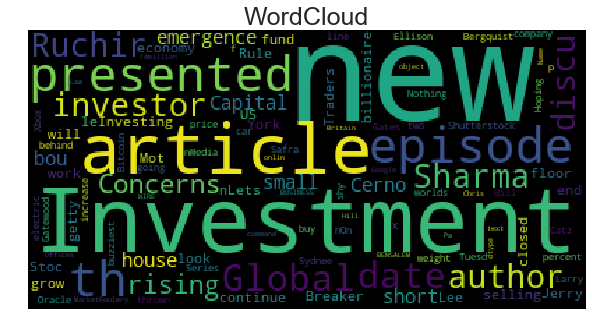

In [98]:
# Generate the word cloud
returns_big_text= ''.join (str (stock_sentiment_df["text"]))

returns_wc= WordCloud().generate(returns_big_text)

plt.imshow(returns_wc)
plt.axis("off")
plt.title('WordCloud', fontsize= 25)
plt.show()